# Descrição de Atividade

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

Baixe os dados [aqui](https://canvas.instructure.com/courses/1389733/files/69523670/download?verifier=A5EPvssqIQCjlxpWQyesLFer1VDTlRyTAAXR2iyi&wrap=1) (veja descrição dos dados mais abaixo).

Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para construir seus modelos de regressão. 

Isso implica, dentre outras coisas:
1. Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção;
2. Fazer tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso;
3. Construir modelos de regressão com (ridge e lasso) e sem regularização;
4. Considerar também modelos de regressão não paramétrica como KNN;
5. Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Forests);
6. Tunar os hiperâmetros para cada caso e retornar os rmses de **validação cruzada** para todos os modelos avaliados;
7. Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema;

Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.

_**Dica**: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados._

## Responder:
### Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

**Sobre os dados**

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do [TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/index.html), pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

* **sequencial_candidato**:  (character) id do candidato
* **nome**: (character)
* **uf**: (character)
* **partido**: (character)
* **quantidade_doacoes** : (integer)
* **quantidade_doadores**: (integer) numero de doadores diferentes
* **total_receita**: (double) soma em reais das doacoes
* **media_receita**: (double) media das doacoes
* **recursos_de_outros_candidatos_por_comite**: (double) quantia em reais das doacoes provenientes de outros candidatos ou comite partidário
* **recursos_de_pessoas_fisicas**: (double) quantia em reais das doacoes provenientes de outros CPFs
* **recursos_de_pessoas_juridicas**: (double) quantia em reais das doacoes provenientes de outros CNPJ
* **recursos_proprios**: (double) quantia em reais das doacoes provenientes do proprio candidato
* **recursos_de_partido_politico**: (double) quantia em reais das doacoes provenientes do partido politico do candidato
* **votos**: (integer) variavel alvo. Se refere ao numero de votos na campanha de 2006 e 2010
* **quantidade_despesas**: (integer)
* **quantidade_fornecedores**: (integer) numero de fornecedores por despesas diferentes
* **total_despesa**: (double) soma em reais das despesas de campanha
* **media_despesa**: (double) media das despesas de campanha
* **cargo**: (character)
* **sexo**:  (character)
* **grau**: (character) grau de instrucao do candidato
* **estado_civil**: (character)
* **ocupacao**: (character) ocupacao do candidato

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

sns.set(style="ticks")

%matplotlib inline

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load Data

In [2]:
candidates_df = pd.read_csv('../data/eleicoes_2006_a_2010.csv')
candidates_df.shape

(7330, 23)

In [3]:
candidates_test_df = pd.read_csv('../data/eleicoes_2014.csv')
candidates_test_df.shape

(4936, 23)

### Remove Colunas Desnecessárias para Análise

In [4]:
candidates_df = candidates_df.drop(columns=['sequencial_candidato', 'nome'])
candidates_test_df = candidates_test_df.drop(columns=['sq_candidato', 'nome_candidato'])

### Renomeação de Colunas de Dataset de Testes

In [5]:
candidates_test_df.rename(columns={'sigla_uf':'uf',
                          'sigla_partido':'partido',
                          'qtd_doacoes':'quantidade_doacoes',
                          'qtd_doadores':'quantidade_doadores',
                          'recursos de outros candidatos/comitês':'recursos_de_outros_candidatos_comites',
                          'recursos de pessoas físicas':'recursos_de_pessoas_fisicas',
                          'recursos de pessoas jurídicas':'recursos_de_pessoas_juridicas',
                          'recursos próprios':'recursos_proprios',
                          'qtd_despesas':'quantidade_despesas',
                          'qtd_fornecedores':'quantidade_fornecedores',
                          'descricao_cargo':'cargo',
                          'grau_instrucao':'grau',
                          'descricao_ocupacao':'ocupacao'}, 
                 inplace=True)

## EDA - Exploratory Data Analysis

Inicialmente, devemos fazer uma análise exploratória dos dados para descobrir como eles estão distribuídos, se possuem valores extraordinários (outliers) e se tem alguma correlação mais forte entre si, especialmente com a variável alvo (**votos**).

In [6]:
candidates_df.columns

Index(['ano', 'uf', 'partido', 'quantidade_doacoes', 'quantidade_doadores',
       'total_receita', 'media_receita',
       'recursos_de_outros_candidatos_comites', 'recursos_de_pessoas_fisicas',
       'recursos_de_pessoas_juridicas', 'recursos_proprios',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao',
       'votos'],
      dtype='object')

In [7]:
candidates_test_df.columns

Index(['ano', 'uf', 'partido', 'quantidade_doacoes', 'quantidade_doadores',
       'total_receita', 'media_receita',
       'recursos_de_outros_candidatos_comites', 'recursos_de_pessoas_fisicas',
       'recursos_de_pessoas_juridicas', 'recursos_proprios',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao',
       'votos'],
      dtype='object')

In [8]:
candidates_df.describe(exclude=['category', 'object'])

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos_comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,7330.000000,7330.000000,7330.000000,7.169000e+03,7169.000000,4.940000e+03,4.647000e+03,3.354000e+03,4.942000e+03,7330.000000,7330.000000,7.330000e+03,7330.000000,7.330000e+03
mean,2008.151160,28.310095,25.817462,1.544899e+05,5485.597708,3.002116e+04,3.730931e+04,1.761195e+05,3.914169e+04,133.339836,110.179945,1.588707e+05,1500.033736,2.280617e+04
std,1.994416,118.655091,103.659438,3.953880e+05,14116.531491,1.280932e+05,8.215398e+04,3.517541e+05,1.839980e+05,416.838801,338.493008,3.951814e+05,6363.830635,4.810133e+04
min,2006.000000,1.000000,1.000000,0.000000e+00,0.000000,2.410000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00
25%,2006.000000,4.000000,4.000000,2.700000e+03,622.857143,1.180000e+03,2.000000e+03,3.422500e+03,1.177233e+03,6.000000,5.000000,2.781405e+03,398.452936,8.600000e+02
50%,2010.000000,9.000000,8.000000,1.209578e+04,1540.542500,3.522570e+03,9.000000e+03,2.612000e+04,5.000000e+03,21.000000,18.000000,1.297986e+04,794.678212,3.025000e+03
75%,2010.000000,24.000000,22.000000,8.929956e+04,4662.500000,1.327550e+04,3.756234e+04,1.755218e+05,2.027459e+04,83.000000,71.000000,1.006515e+05,1564.290552,2.027450e+04
max,2010.000000,6997.000000,5800.000000,4.539727e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,9932.000000,8359.000000,4.989491e+06,500177.000000,1.353820e+06


In [9]:
candidates_test_df.describe(exclude=['category','object'])

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos_comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,4936.0,4936.000000,4936.000000,4.936000e+03,4936.000000,3.191000e+03,3.727000e+03,1.714000e+03,2.860000e+03,4936.000000,4936.000000,4.936000e+03,4936.000000,4.936000e+03
mean,2014.0,24.809765,21.216572,2.005536e+05,6135.051733,3.349950e+04,4.084598e+04,2.036965e+05,4.356332e+04,148.208671,117.088736,2.051600e+05,1345.348445,1.780833e+04
std,0.0,49.980431,40.888475,5.347148e+05,14250.293622,1.139275e+05,1.085905e+05,4.256615e+05,1.757768e+05,441.152375,347.458705,5.537136e+05,1877.675782,4.641931e+04
min,2014.0,1.000000,1.000000,3.000000e-01,0.300000,1.500000e-01,1.000000e-02,1.170000e+00,2.000000e-01,1.000000,1.000000,7.200000e-01,0.720000,0.000000e+00
25%,2014.0,5.000000,4.000000,3.025785e+03,606.562500,1.087750e+03,1.100000e+03,3.000000e+03,1.200000e+03,6.000000,5.000000,3.026463e+03,470.965998,4.740000e+02
50%,2014.0,9.000000,9.000000,1.143493e+04,1416.698571,4.205000e+03,4.500000e+03,2.793599e+04,5.005000e+03,17.000000,15.000000,1.143633e+04,857.971212,1.705500e+03
75%,2014.0,22.000000,19.000000,8.882676e+04,4599.437500,1.921249e+04,2.746000e+04,2.007535e+05,2.183443e+04,72.000000,60.000000,9.013437e+04,1533.463301,1.044750e+04
max,2014.0,928.000000,873.000000,5.836140e+06,281250.000000,1.788100e+06,1.826762e+06,3.828338e+06,3.752000e+06,6413.000000,5170.000000,7.420179e+06,35520.493556,1.524361e+06


A tabela acima já nos permite tirar uma série de insights sobre os dados que temos, entretando precisamos investigar a existência de valores estranhos no nosso dataset, como valores não-numéricos (NaN) em variáveis numéricas:

In [10]:
for col in candidates_df.columns:
    amount_nan = candidates_df[str(col)].isna().sum()
    if amount_nan > 0:
        print("Column [{:02}]: {:40} - Amount NaN: {}".format(candidates_df.columns.get_loc(str(col)), str(col), amount_nan))

Column [05]: total_receita                            - Amount NaN: 161
Column [06]: media_receita                            - Amount NaN: 161
Column [07]: recursos_de_outros_candidatos_comites    - Amount NaN: 2390
Column [08]: recursos_de_pessoas_fisicas              - Amount NaN: 2683
Column [09]: recursos_de_pessoas_juridicas            - Amount NaN: 3976
Column [10]: recursos_proprios                        - Amount NaN: 2388


Faz o mesmo para o dataset de testes

In [11]:
for col in candidates_test_df.columns:
    amount_nan = candidates_test_df[str(col)].isna().sum()
    if amount_nan > 0:
        print("Column [{:02}]: {:40} - Amount NaN: {}".format(candidates_test_df.columns.get_loc(str(col)), str(col), amount_nan))

Column [07]: recursos_de_outros_candidatos_comites    - Amount NaN: 1745
Column [08]: recursos_de_pessoas_fisicas              - Amount NaN: 1209
Column [09]: recursos_de_pessoas_juridicas            - Amount NaN: 3222
Column [10]: recursos_proprios                        - Amount NaN: 2076


Para essas variáveis não podemos ter valores não numéricos, então vamos colocar esses valores para 0.0, uma vez que são valores de receita e recursos.

In [12]:
candidates_df.total_receita.fillna(0, inplace=True)
candidates_df.media_receita.fillna(0, inplace=True)
candidates_df.recursos_de_outros_candidatos_comites.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_fisicas.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_juridicas.fillna(0, inplace=True)
candidates_df.recursos_proprios.fillna(0, inplace=True)

Faz o mesmo para os dados de teste

In [13]:
candidates_test_df.recursos_de_outros_candidatos_comites.fillna(0, inplace=True)
candidates_test_df.recursos_de_pessoas_fisicas.fillna(0, inplace=True)
candidates_test_df.recursos_de_pessoas_juridicas.fillna(0, inplace=True)
candidates_test_df.recursos_proprios.fillna(0, inplace=True)

### Calculando Skewness de Variáveis Numéricas

Aqui nós transformamos skewed features para que tenham uma distribuição mais normalizada. Ter uma distribuição mais normalizada nos garante um maior arsenal de ferramentas estatísticas e computacionais que podemos utilizar, assim como torna a análise dos dados mais conveniente para nós.

Nós utilizamos o **log(1 + x)** em vez de apenas **log(x)**, uma vez que o log de 0 não existe, e várias de nossas variáveis tem esses valores, como as que preenchemos em substituição a NaN na seção acima. Além disso, como estamos lidando com valores de receita, despesa, etc. é comum ter valores 0 em nossas distribuições.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb38566048>,
      dtype=object)

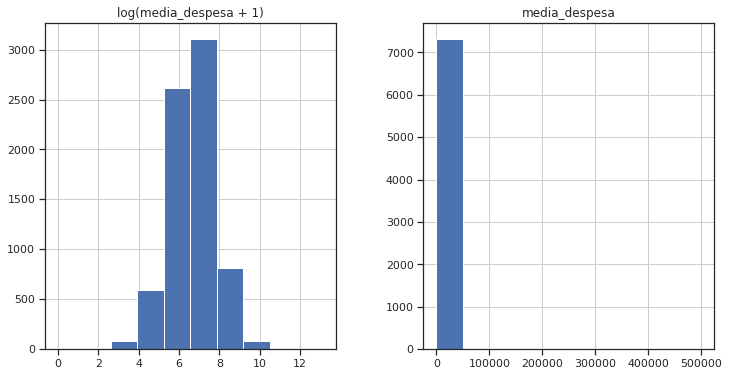

In [14]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
media_despesa = pd.DataFrame({"media_despesa" : candidates_df["media_despesa"], "log(media_despesa + 1)" : np.log1p(candidates_df["media_despesa"])})
media_despesa.hist()

In [15]:
numeric_features = candidates_df.dtypes[candidates_df.dtypes != 'object'].index

skewed_feats = candidates_df[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

print(skewed_feats)

candidates_df[skewed_feats] = np.log1p(candidates_df[skewed_feats])

Index(['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos_comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'votos'],
      dtype='object')


Importante notar que a variável-alvo **_votos_** também está incluída no conjunto de skewed variables, e não precisa ser transformada em separado.

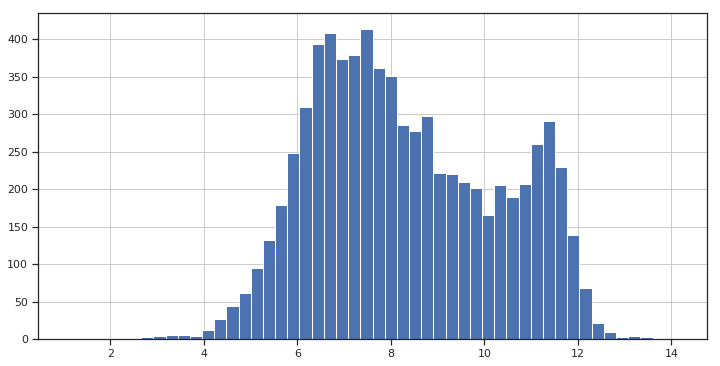

In [16]:
candidates_df.votos.hist(bins=50)

Faz o mesmo para o dataset de testes

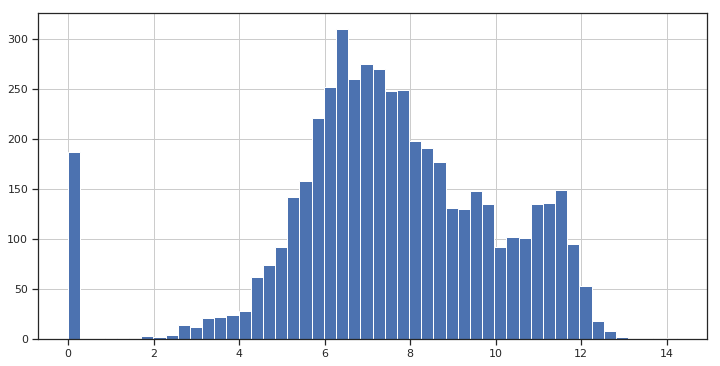

In [17]:
numeric_features = candidates_test_df.dtypes[candidates_test_df.dtypes != 'object'].index

skewed_feats = candidates_test_df[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

candidates_test_df[skewed_feats] = np.log1p(candidates_test_df[skewed_feats])

candidates_test_df.votos.hist(bins=50)

### Variáveis Categóricas

Como estamos trabalhando com modelos que apenas aceitam variáveis numéricas, precisamos também transformar variáveis categóricas do nosso dataset em variáveis numéricas com as quais nosso modelo de machine learning pode trabalhar. As variáveis não-numéricas (categóricas) que temos são as seguintes:

In [18]:
cat_variables = []

for col in candidates_df.columns:
    if not np.issubdtype(candidates_df[str(col)].dtype, np.number) and col != 'nome':
        cat_variables.append(col)
        print("Column [{:02}]: {:40}".format(candidates_df.columns.get_loc(str(col)), str(col)))

Column [01]: uf                                      
Column [02]: partido                                 
Column [15]: cargo                                   
Column [16]: sexo                                    
Column [17]: grau                                    
Column [18]: estado_civil                            
Column [19]: ocupacao                                


Vamos verificar a distribuição dessas variáveis, exceto **nome**, para entender como e se podemos transformar todas para um valor inteiro.

Para o dataset de testes:

In [19]:
cat_variables_test = []

for col in candidates_test_df.columns:
    if not np.issubdtype(candidates_test_df[str(col)].dtype, np.number) and col != 'nome':
        cat_variables_test.append(col)
        print("Column [{:02}]: {:40}".format(candidates_test_df.columns.get_loc(str(col)), str(col)))

Column [01]: uf                                      
Column [02]: partido                                 
Column [15]: cargo                                   
Column [16]: sexo                                    
Column [17]: grau                                    
Column [18]: estado_civil                            
Column [19]: ocupacao                                


#### Distribuição das Variáveis Categóricas

Façamos agora uma análise das distribuições das variáveis categóricas no dataset de **treino e validação**.

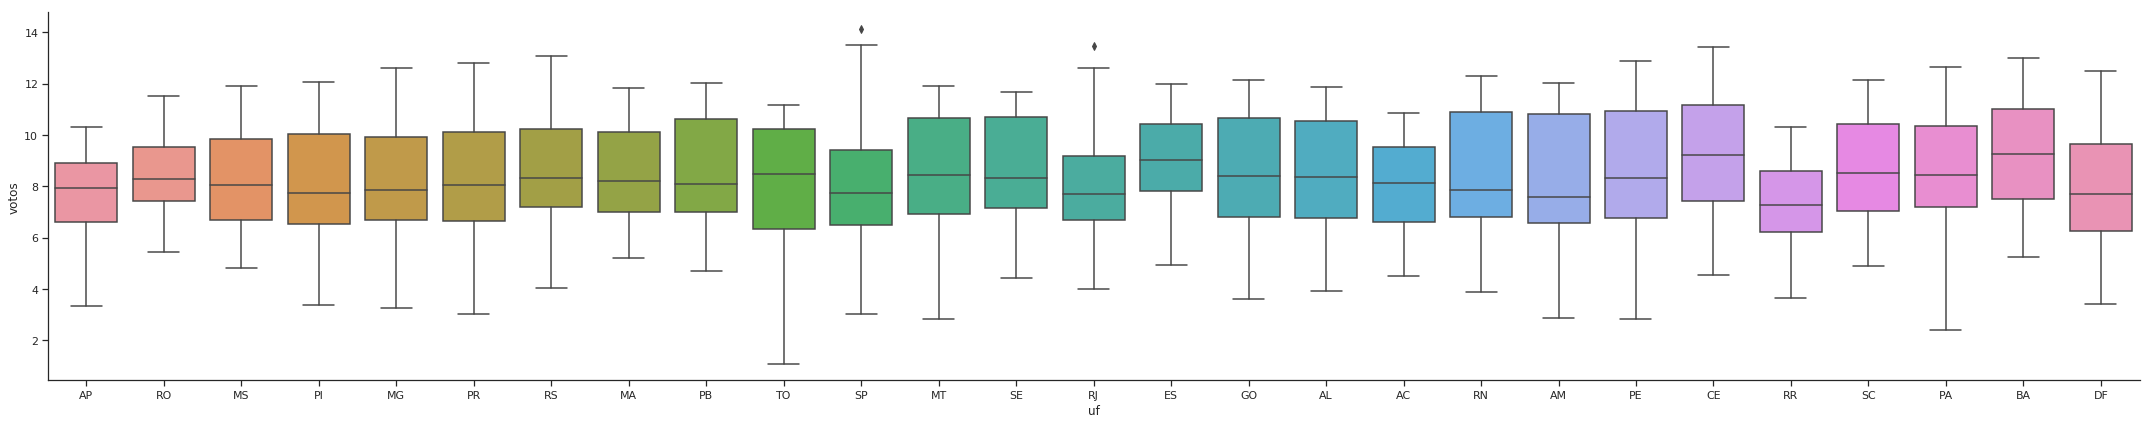

In [20]:
sns.catplot(x='uf', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

Aqui podemos aplicar uma função e transformar cada estado para um código numérico:

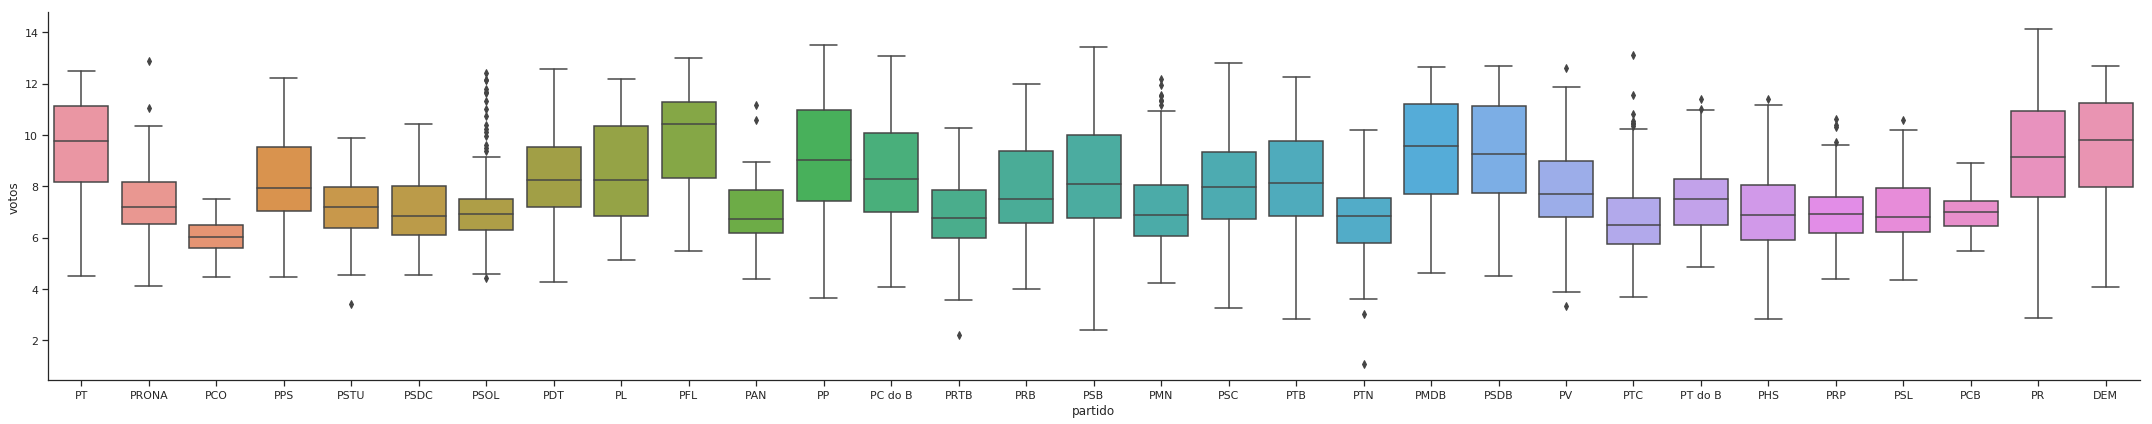

In [21]:
sns.catplot(x='partido', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

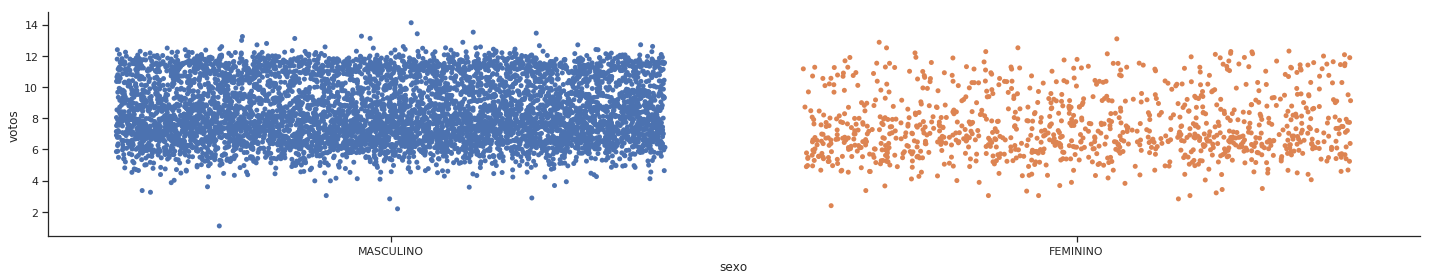

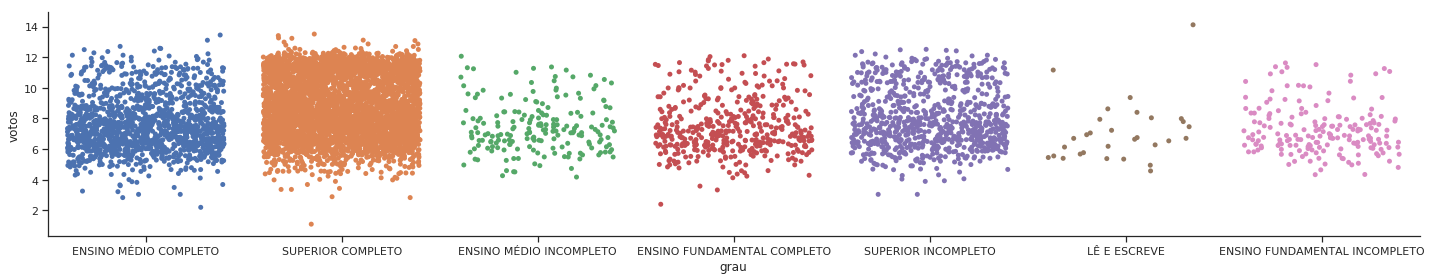

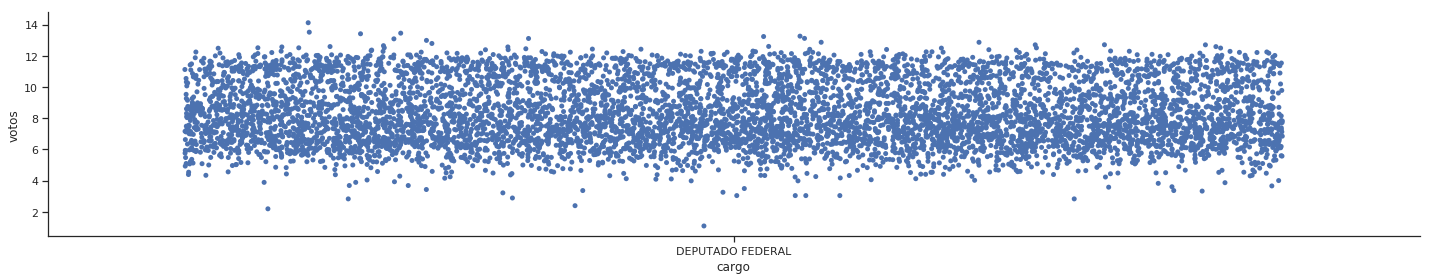

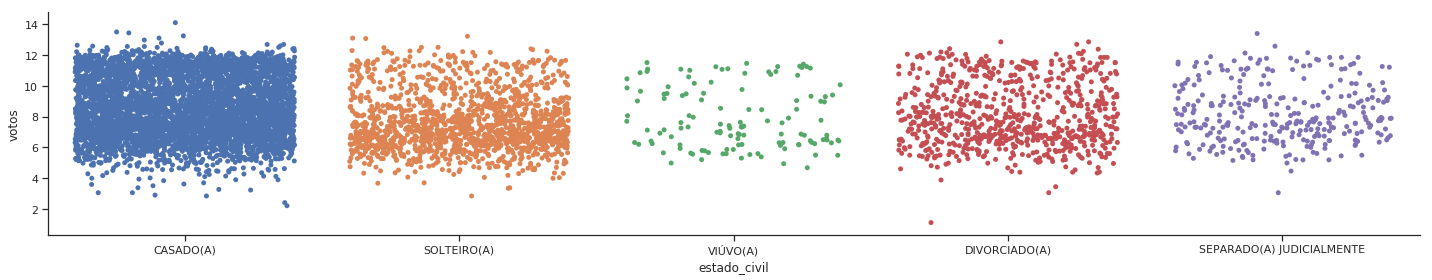

In [22]:
for col in ['sexo', 'grau', 'cargo', 'estado_civil']:
    sns.catplot(x=col, y='votos', data=candidates_df, jitter=.4, aspect=5, height=4)

Note que podemos tratar a variável **grau** como uma variável ordinária:

In [23]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}

candidates_df.replace(cleanup_nums, inplace=True)
candidates_test_df.replace(cleanup_nums, inplace=True)

Para a variável **ocupacao** nós temos um conjunto muito grande de diferentes valores, o que inviabiliza a exposição gráfica de todos os valores, entretando nós expomos aqui as quantidades para as 20 ocupações mais comuns:

In [24]:
candidates_df.ocupacao.value_counts().head(10)

OUTROS                       819
DEPUTADO                     703
ADVOGADO                     673
EMPRESÁRIO                   629
VEREADOR                     326
MÉDICO                       325
COMERCIANTE                  316
SERVIDOR PÚBLICO ESTADUAL    248
SERVIDOR PÚBLICO FEDERAL     214
PROFESSOR DE ENSINO MÉDIO    172
Name: ocupacao, dtype: int64

### Dummy Variables

Para transformar essas variáveis categóricas em numéricas (dummy variables), utilizamos uma função especial da biblioteca _pandas_. Contudo nós precisamos concatenar os datasets de treino e validação com o de testes, caso contrário, teremos _features_ que serão modeladas para um dataset e não existirão em outro, o que causa a incompatibilidade e consequentemente a impossibilidade de utilização dos dados de **teste** no modelo gerado com os dados de **treino e validação**.

Antes de criar as variáveis dummy, vamos descobrir quais as quantidade de valores únicos para cada uma das variáveis categóricas que temos em mãos. Assim, nós podemos identificar quais valores de variáveis existem no dataset de _teste_, mas não existem no de _treino e validação_ (**no qual nos baseamos para criarmos o modelo preditor**) e então nós podemos fazer os ajustes necessários.

In [25]:
print("Dataset de Treino e Validação")    
for cat_var in cat_variables:
    print("Variável: {} - Número de Valores Únicos: {}".format(cat_var, candidates_df[cat_var].nunique()))

print()    

print("Dataset de Testes:")
for cat_var in cat_variables_test:
    print("Variável: {} - Número de Valores Únicos: {}".format(cat_var, candidates_test_df[cat_var].nunique()))

Dataset de Treino e Validação
Variável: uf - Número de Valores Únicos: 27
Variável: partido - Número de Valores Únicos: 31
Variável: cargo - Número de Valores Únicos: 1
Variável: sexo - Número de Valores Únicos: 2
Variável: grau - Número de Valores Únicos: 7
Variável: estado_civil - Número de Valores Únicos: 5
Variável: ocupacao - Número de Valores Únicos: 175

Dataset de Testes:
Variável: uf - Número de Valores Únicos: 27
Variável: partido - Número de Valores Únicos: 32
Variável: cargo - Número de Valores Únicos: 1
Variável: sexo - Número de Valores Únicos: 2
Variável: grau - Número de Valores Únicos: 7
Variável: estado_civil - Número de Valores Únicos: 5
Variável: ocupacao - Número de Valores Únicos: 159


Identificando valores de variáveis categóricas presentes no dataset de _testes_ mas não no dataset de _treino e validação_.

In [26]:
dic_catvar_uniques = {}

for cat_var in cat_variables:
    dic_catvar_uniques[cat_var] = set(candidates_df[cat_var].unique())
    set_uni_val_test_dataset = set(candidates_test_df[cat_var].unique())
    dic_catvar_uniques[cat_var] = set_uni_val_test_dataset.union(dic_catvar_uniques[cat_var])

for key,val in dic_catvar_uniques.items():
    print("Variável: {} - Num Unique Values: {}".format(key, len(val)))

Variável: uf - Num Unique Values: 27
Variável: partido - Num Unique Values: 36
Variável: cargo - Num Unique Values: 1
Variável: sexo - Num Unique Values: 2
Variável: grau - Num Unique Values: 7
Variável: estado_civil - Num Unique Values: 5
Variável: ocupacao - Num Unique Values: 192


Como podemos ver, os valores de **partido** e **ocupacao** são as variáveis críticas com as quais precisamos nos preocupar no momento de fazer o _dummy_ das variáveis categóricas. 

Abaixo, nós concatenamos os datasets de **_treino e validação_** e o dataset de **_teste_** e então criamos as variáveis _dummy_. Em seguida separamos o dataset em treino e teste novamente baseado no valor de **ano**.

Essa abordagem resolve o problema levantado acima, fazendo com que tenhamos ao final o mesmo número de variáveis nos datasets de treino e de teste.

In [27]:
candidates_train_test_df = pd.concat([candidates_df, candidates_test_df])
candidates_train_test_df = pd.get_dummies(candidates_train_test_df)
candidates_train_test_df.shape

(12266, 278)

In [28]:
candidates_df = candidates_train_test_df[(candidates_train_test_df.ano == 2006) | (candidates_train_test_df.ano == 2010)]
candidates_df.shape

(7330, 278)

In [29]:
candidates_test_df = candidates_train_test_df[candidates_train_test_df.ano == 2014]
candidates_test_df.shape

(4936, 278)

### Distribuição de Variáveis Numéricas

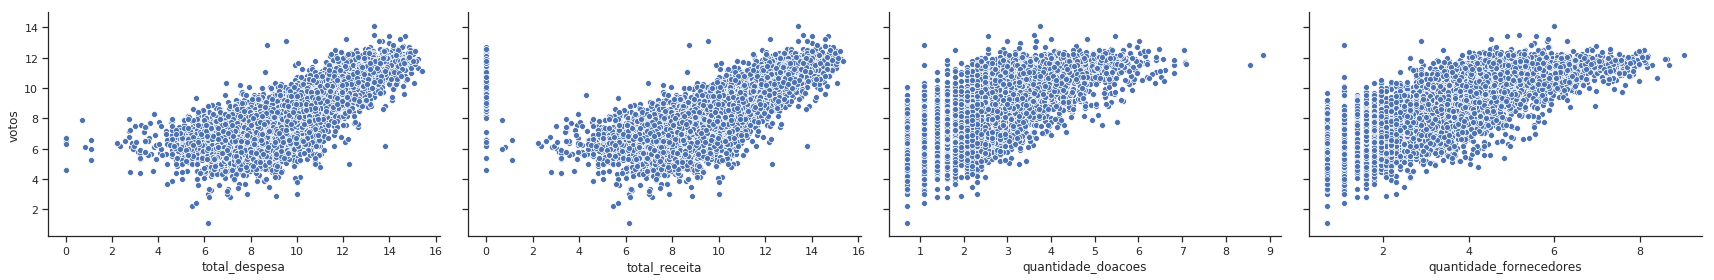

In [30]:
sns.pairplot(candidates_df, x_vars=['total_despesa', 'total_receita', 'quantidade_doacoes', 'quantidade_fornecedores'], y_vars=['votos'], aspect=1.5, height=4)

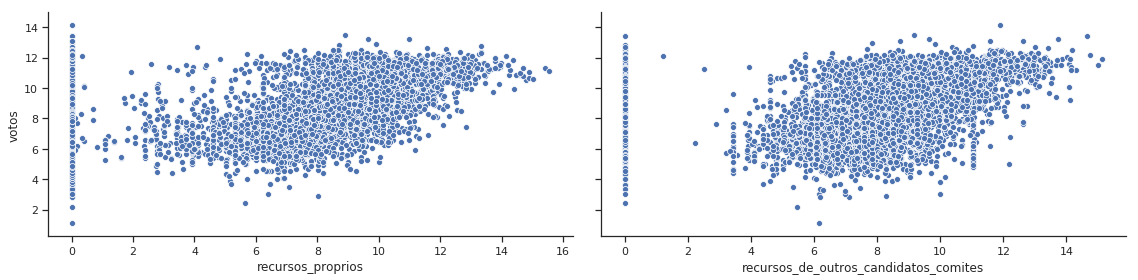

In [31]:
sns.pairplot(candidates_df, x_vars=['recursos_proprios', 'recursos_de_outros_candidatos_comites'], y_vars=['votos'], aspect=2, height=4)

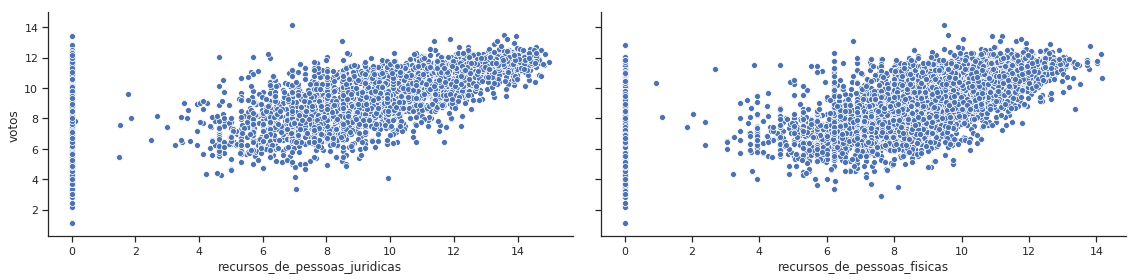

In [32]:
sns.pairplot(candidates_df, x_vars=['recursos_de_pessoas_juridicas', 'recursos_de_pessoas_fisicas'], y_vars=['votos'], aspect=2, height=4)

## Modelos - Versão 1

Nesta versão, utilizamos como dados de treino, os dados da eleição de 2006, e como dados de teste, os dados da eleição de 2010. Em um segundo momento, utilizaremos os dados da eleição de 2014 como dados de teste.

In [33]:
candidates_train = candidates_df[candidates_df.ano == 2006]
candidates_val = candidates_df[candidates_df.ano == 2010]

feats = candidates_df.columns[candidates_df.columns != 'votos']

X_train = candidates_train[feats]
y_train = candidates_train['votos']

X_val = candidates_val[feats]
y_val = candidates_val['votos']

### Validação Cruzada

Abaixo definimos uma adaptação de uma função criada por Alexandru Papiu em [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models), que nos retorna a média dos RMSE's de um dado modelo para uma cross-validation no dataset de treino e um k-fold com k = 5.

In [34]:
def mean_rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)).mean()

### Sem Regularização


In [35]:
lr = LinearRegression().fit(X_train, y_train)
predictions = lr.predict(X_val)

print("RMSE Linear Regressor - Train - Cross-Validated: {:2.3}".format(mean_rmse_cv(lr)))
print("RMSE Linear Regressor - Validation: {:2.3}".format(np.sqrt(mean_squared_error(y_pred=predictions, y_true=y_val))))

RMSE Linear Regressor - Train - Cross-Validated: 9.25e+08
RMSE Linear Regressor - Validation: 1.48e+09


Como podemos observar, os valores de RMSE para um modelo linear multivariado sem regularização tem um erro bastante elevado. Isso provavelmente se deve ao fato de está acontecendo overfitting. Uma simples olhada na ordem dos coeficientes do modelo nos permite observar isso. Caso os coeficientes sejam muito grandes, temos overfitting.

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


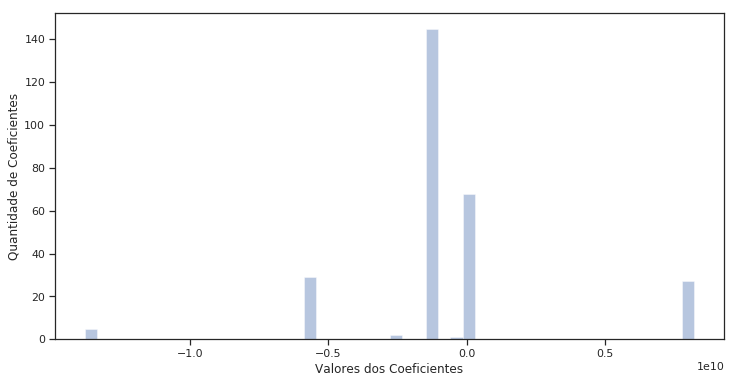

In [36]:
coefs = lr.coef_
ax = sns.distplot(coefs, kde=False)
ax.set(xlabel='Valores dos Coeficientes', ylabel='Quantidade de Coeficientes')
plt.show()

##### **Plot Resíduos vs Predições - Linear Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

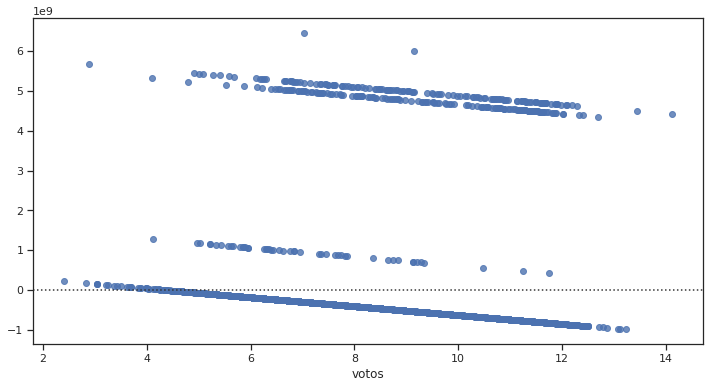

In [37]:
sns.residplot(y_val, predictions)

Como vemos, nosso modelo feito com um Linear Regressor sem regularização não é um bom preditor: nós não observamos padrões visuais surgindo na distribuição dos resíduos, o que é um mal indício de adequabilidade do modelo, existem características que não estão sendo corretamente capturadas. E também os pontos estão concentrados aleatoriamente ao redor da linha nula (0).

### Com Regularização

#### **_Ridge_**

Text(0,0.5,'rmse')

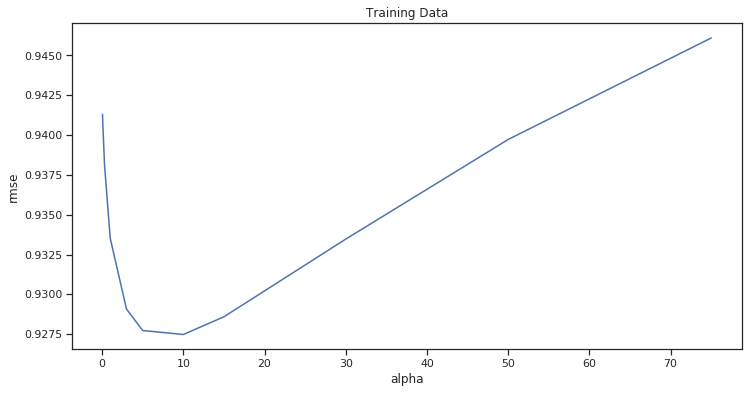

In [38]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

ridge_train_rmses = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    ridge_train_rmses.append(mean_rmse_cv(ridge))

cv_ridge_train = pd.Series(ridge_train_rmses, index = alphas)

cv_ridge_train.plot(title = "Training Data")
plt.xlabel("alpha")
plt.ylabel("rmse")

O valor de **alpha** associado com o menor RMSE é **10**. Então vamos utilizar esse valor para configurar nosso modelo de regressão linear Ridge, o qual utiliza normalização **l2**. O valor de RMSE encontrado para alpha = 10 é em torno de 1.02.

In [39]:
cv_ridge_train.min()

0.9274852452674887

In [40]:
ridge = Ridge(alpha = 10).fit(X_train, y_train)
predictions = ridge.predict(X_val)
print("RMSE Ridge Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(ridge)))
print("RMSE Ridge Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

RMSE Ridge Regressor - Train - Cross-Validated: 0.9274852
RMSE Ridge Regressor - Validation: 1.025357


##### **Plot Resíduos vs Predições - Ridge**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

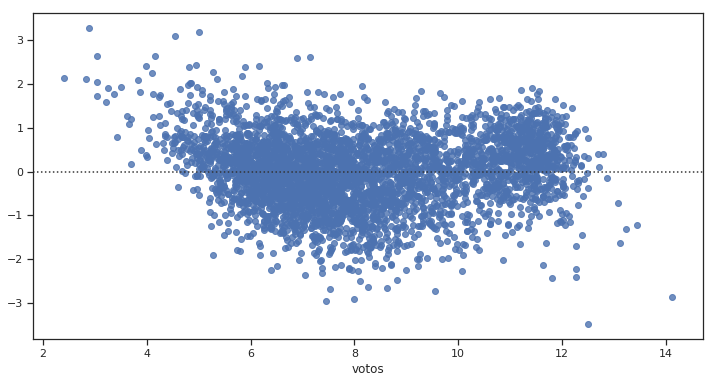

In [41]:
sns.residplot(y_val, predictions)

Como vemos, nosso modelo Ridge é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

#### **_Lasso_**

In [42]:
model_lasso = LassoCV(alphas = [1, 5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5, 1e-6], max_iter=1e5).fit(X_train, y_train)
predictions = model_lasso.predict(X_val)
print("RMSE Lasso Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(model_lasso)))
print("RMSE Lasso Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

RMSE Lasso Regressor - Train - Cross-Validated: 0.9282049
RMSE Lasso Regressor - Validation: 1.025778


O modelo Ridge se sai um pouco melhor que o modelo Lasso. Complementando a análise, podemos identificar quais variáveis foram consideradas ou eliminadas pelo modelo de regressão Lasso.

In [43]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 99 variables and eliminated the other 178 variables


Text(0.5,1,'Coefficients in the Lasso Model')

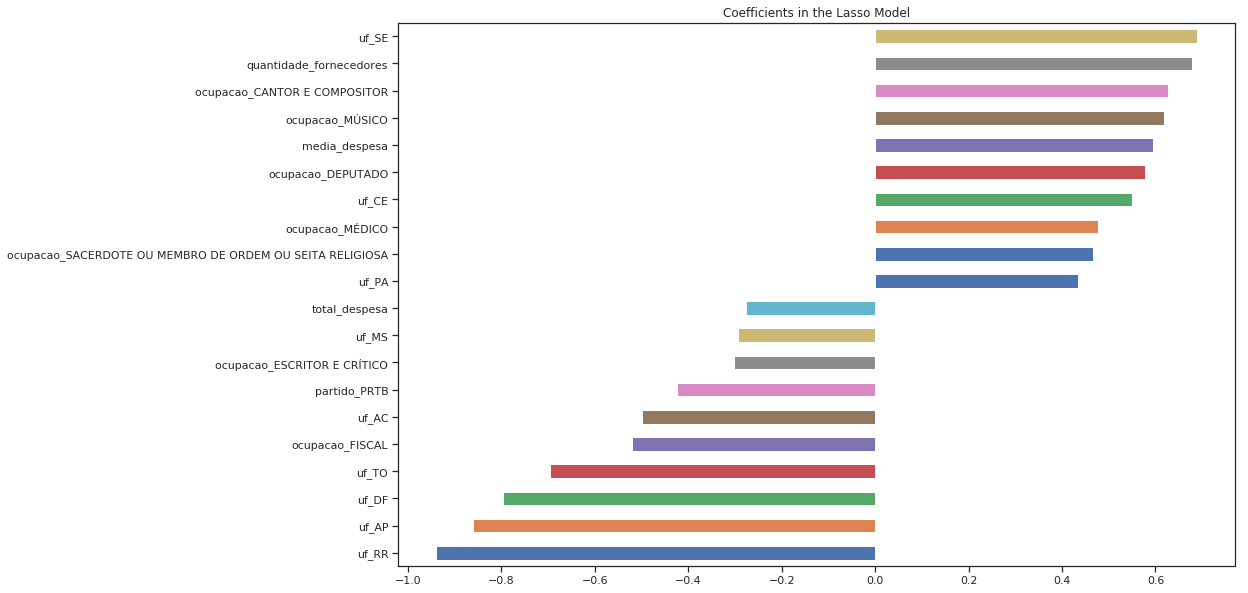

In [44]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

##### **Plot Resíduos vs Predições - Lasso**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

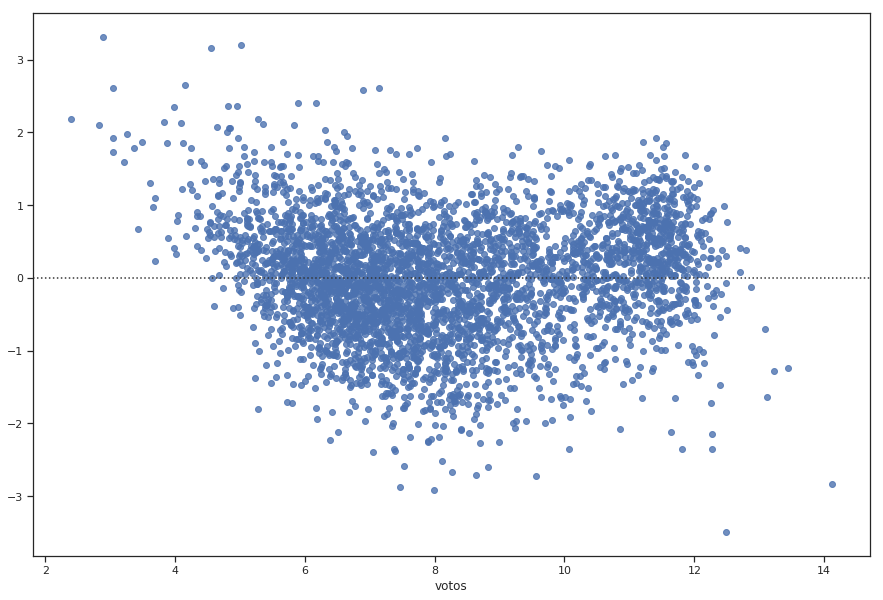

In [45]:
predictions = model_lasso.predict(X_val)
sns.residplot(y_val, predictions)

Como vemos, nosso modelo Lasso é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

### Non-Parameterized Models

#### **_KNN (K-Nearest Neighbors)_**

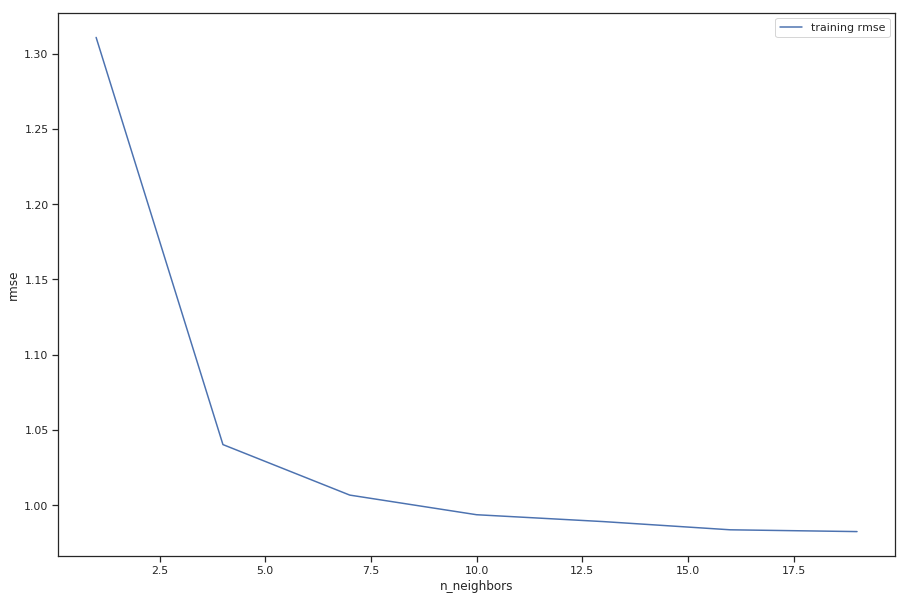

In [46]:
training_rmse = []

neighbors_settings = range(1, 20, 3)

for n_neighbors in neighbors_settings:
    knr = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train, y_train)
    training_rmse.append(mean_rmse_cv(knr))
    
plt.plot(neighbors_settings, training_rmse, label="training rmse")
plt.ylabel("rmse")
plt.xlabel("n_neighbors")
plt.legend()

Aparentemente, o melhor número para K é 18, a partir do qual, os valores de acurácia começam a ser aproximadamente o mesmo. Vamos fazer a análise utilizando as funções para cálculo de RMSE:

In [47]:
knr = KNeighborsRegressor(n_neighbors = 18).fit(X_train, y_train)
predictions = knr.predict(X_val)

print("RMSE KNN Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(knr)))
print("RMSE KNN Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

RMSE KNN Regressor - Train - Cross-Validated: 0.9832987
RMSE KNN Regressor - Validation: 1.080436


##### **Plot Resíduos vs Predições - KNN**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

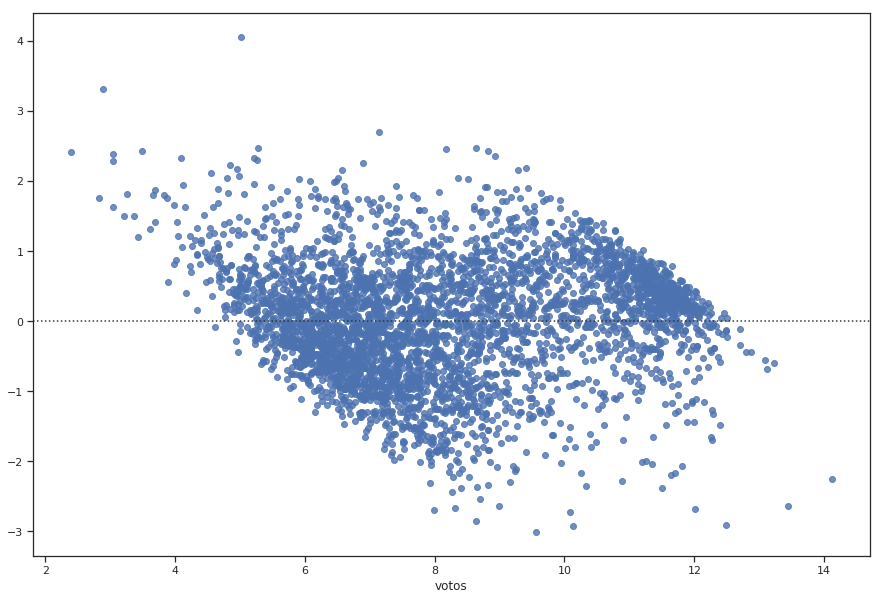

In [48]:
sns.residplot(y_val, predictions)

### Modelos Extra

Nessa sessão vamos testar a eficiência em termos de RMSE, quando utilizamos um Ensemble Random Forest Regressor.

#### **_Random Forest Regressor_**

In [49]:
rf = RandomForestRegressor(random_state = 2).fit(X_train, y_train)
predictions = rf.predict(X_val)

print("RMSE Random Forest Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(rf)))
print("RMSE Random Forest Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

RMSE Random Forest Regressor - Train - Cross-Validated: 0.9772526
RMSE Random Forest Regressor - Validation: 1.12543


##### **Plot Resíduos vs Predições - Random Forest**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

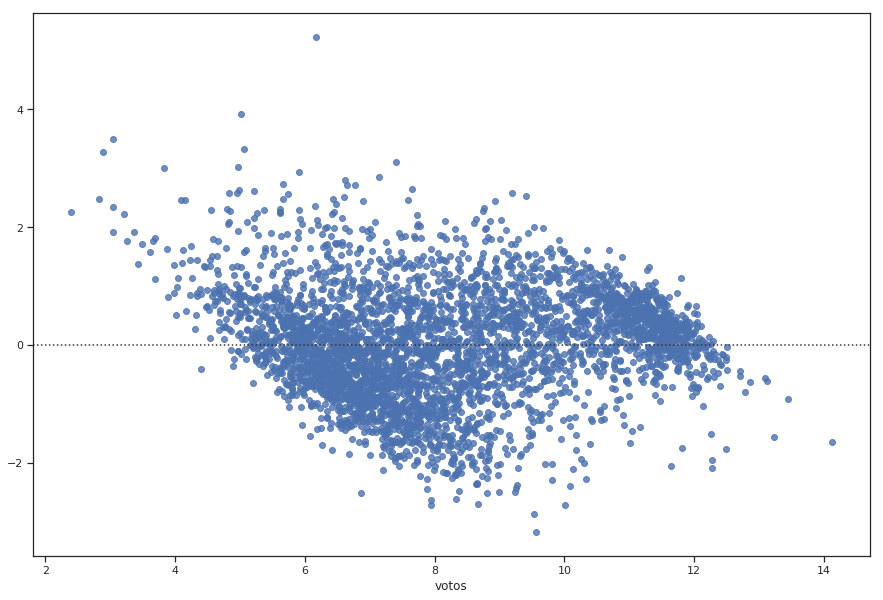

In [50]:
sns.residplot(y_val, predictions)

#### _**Decision Tree Regressor**_

In [51]:
dt = DecisionTreeRegressor(random_state = 2).fit(X_train, y_train)
predictions = dt.predict(X_val)

print("RMSE Decision Tree Regressor - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(dt)))
print("RMSE Decision Tree Regressor - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

RMSE Decision Tree Regressor - Train - Cross-Validated: 1.269809
RMSE Decision Tree Regressor - Validation: 1.368919


##### **Plot Resíduos vs Predições - Decision Tree Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

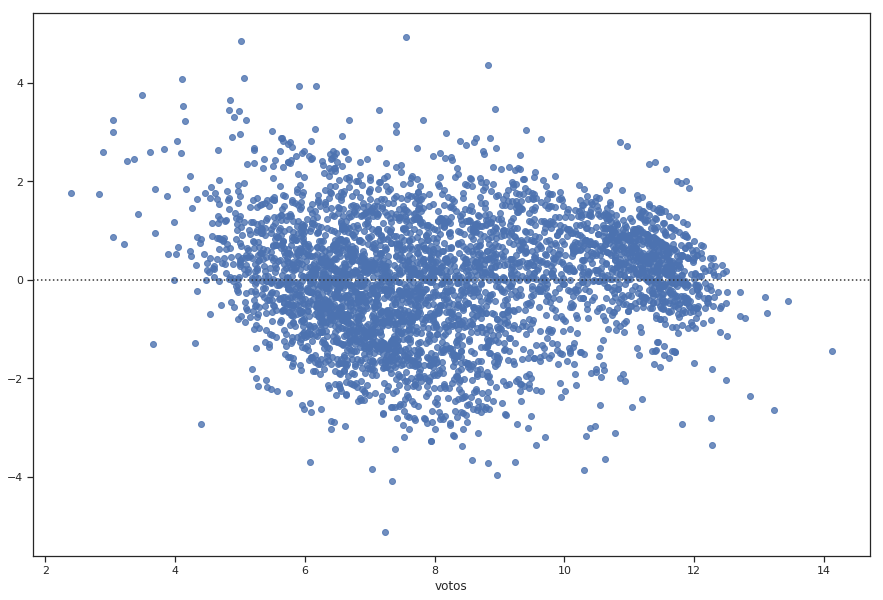

In [52]:
sns.residplot(y_val, predictions)

#### **_Epsilon-Support Vector Regressor_**

In [53]:
svr = SVR().fit(X_train, y_train)
predictions = svr.predict(X_val)

print("RMSE SVR - Train - Cross-Validated: {:2.7}".format(mean_rmse_cv(svr)))
print("RMSE SVR - Validation: {:2.7}".format(np.sqrt(mean_squared_error(y_true=y_val, y_pred=predictions))))

RMSE SVR - Train - Cross-Validated: 0.9205626
RMSE SVR - Validation: 1.102004


##### **Plot Resíduos vs Predições - SVR**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

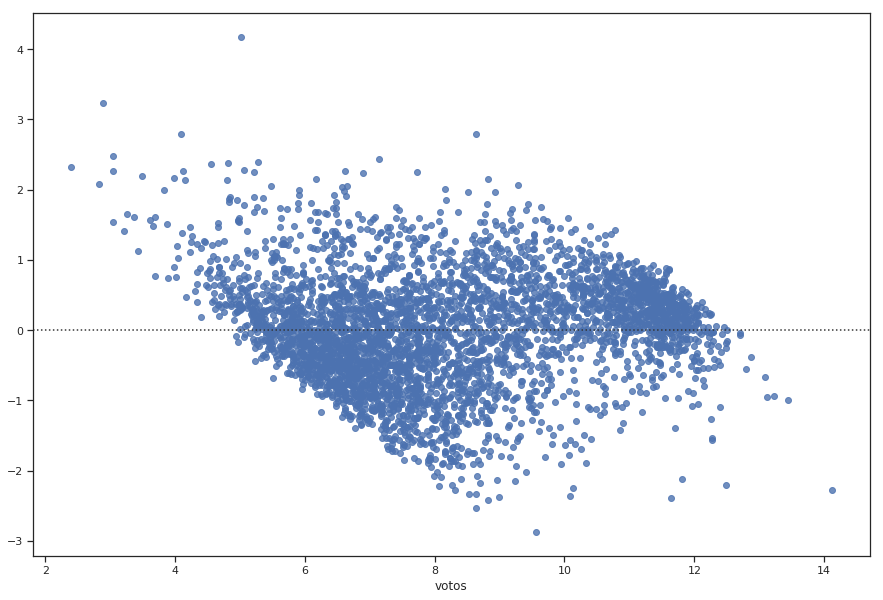

In [54]:
sns.residplot(y_val, predictions)

Como vemos, em termos de RMSE sobre os dados de validação o **Ridge Regressor** é o melhor modelo que encontramos até agora, com o modelo **Lasso Regressor** bem próximo a ele em termos de RMSE.

## Modelos - Versão 2

Abaixo nós vamos unir os dados de treino e validação usados acima (eleições 2006 e 2010), retreinar o melhor algoritmo identificado e usar os dados de teste (eleição de 2014) para verificar seu desempenho em termos de RMSE.

### Definindo Variáveis Dependentes e Independentes

In [55]:
feats = candidates_df.columns[candidates_df.columns != 'votos']

X_train = candidates_df[feats]
y_train = candidates_df['votos']

X_test = candidates_test_df[feats]
y_test = candidates_test_df['votos']

### Sem Regularização


In [56]:
predictions = lr.predict(X_test)
print("RMSE Linear Regressor - Test: {:2.5}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

RMSE Linear Regressor - Test: 2.2276e+09


##### **Plot Resíduos vs Predições - Linear Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

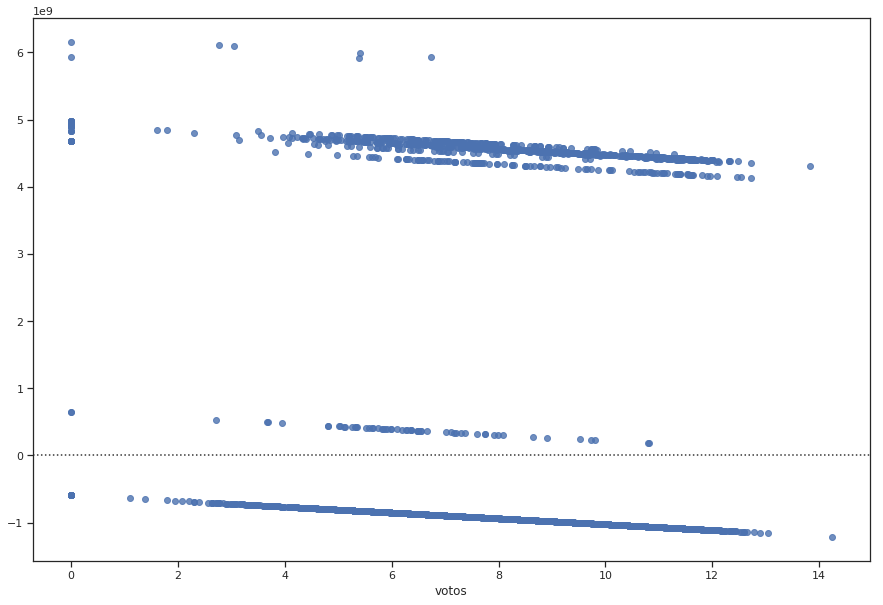

In [57]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo feito com um **Linear Regressor** sem regularização não é um bom preditor: nós não observamos padrões visuais surgindo na distribuição dos resíduos, o que é um mal indício de adequabilidade do modelo, existem características que não estão sendo corretamente capturadas. E também os pontos estão concentrados aleatoriamente ao redor da linha nula (0).

### Com Regularização

#### Ridge

In [58]:
predictions = ridge.predict(X_test)
print("RMSE Ridge Regressor - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

RMSE Ridge Regressor - Test: 1.935311828


##### **Plot Resíduos vs Predições - Ridge**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

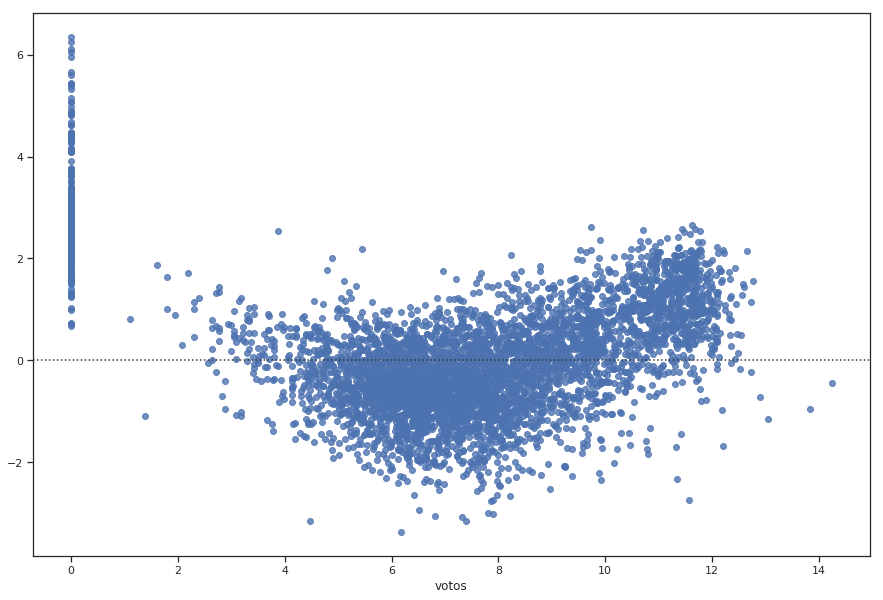

In [59]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **Ridge** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

É possível observar também em destaque que o modelo não consegue prever com acurácia para os casos em que os candidatos recebem zero votos. Isso pode ser explicado pelo fato de se tratarem de **outliers**.

#### Lasso

In [60]:
predictions = model_lasso.predict(X_test)
print("RMSE Lasso Regressor - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

RMSE Lasso Regressor - Test: 1.935028589


O modelo **Lasso Regressor** se sai um pouco melhor que o modelo **Ridge Regressor**.

##### **Plot Resíduos vs Predições - Lasso**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

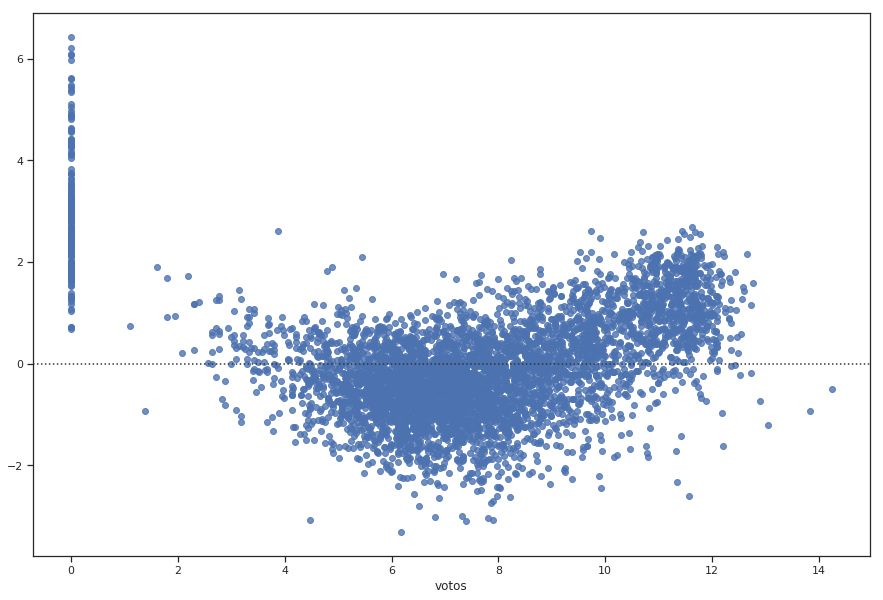

In [61]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **Lasso** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

O modelo Lasso, assim como o Ridge, não consegue prever bem quando os candidatos recebem zero votos.

### Non-Parameterized Models

#### KNN (K-Nearest Neighbors)

In [62]:
predictions = knr.predict(X_test)
print("RMSE KNN Regressor - Test: {:2.5}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

RMSE KNN Regressor - Test: 1.9944


##### **Plot Resíduos vs Predições - KNN**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

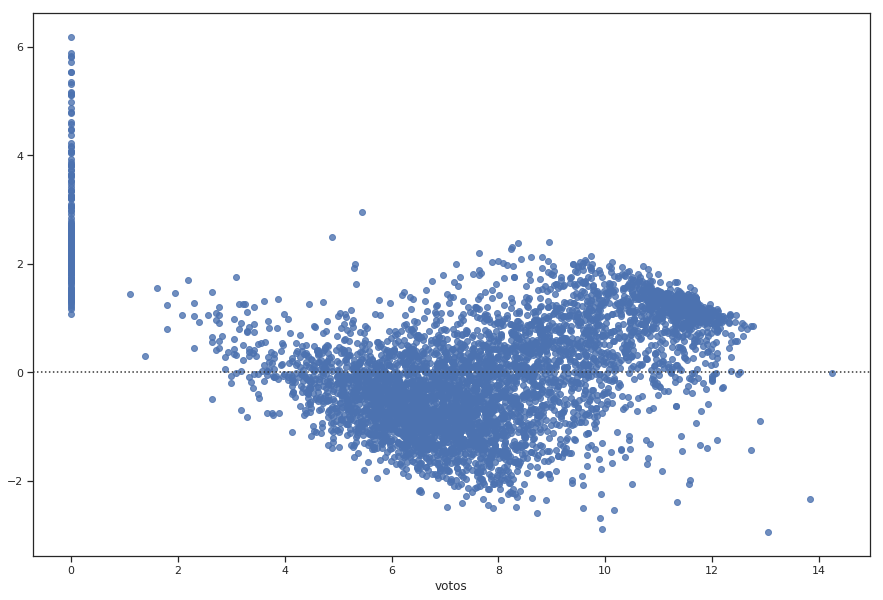

In [63]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **KNN** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0). Entretanto, o modelo não consegue prever bem quando os candidatos recebem zero votos.

### Modelos Extra

Nessa sessão vamos testar a eficiência em termos de RMSE, quando utilizamos um Ensemble Random Forest Regressor.

#### **_Random Forest Regressor_**

In [64]:
predictions = rf.predict(X_test)
print("RMSE Random Forest Regressor - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

RMSE Random Forest Regressor - Test: 2.020674609


##### **Plot Resíduos vs Predições - Random Forests**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

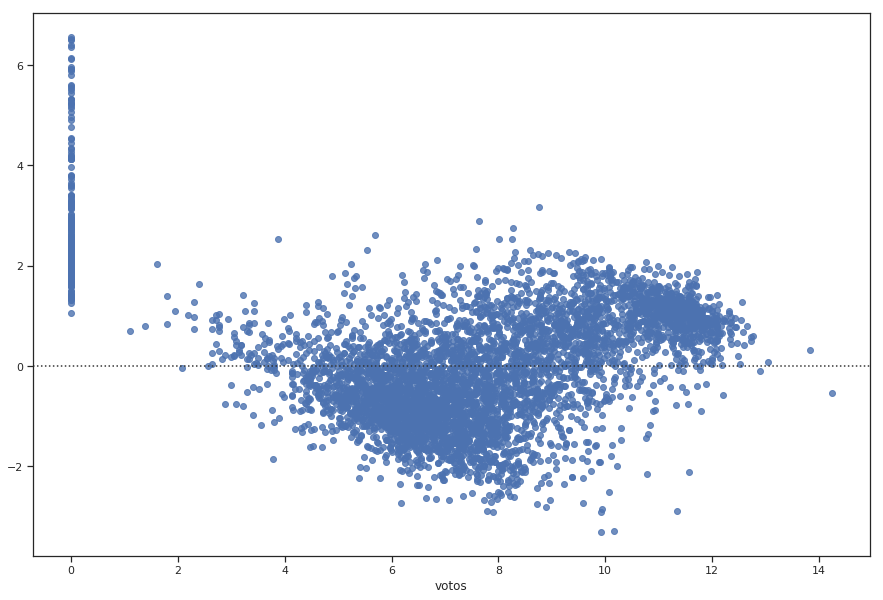

In [65]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **Random Forest** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0). Entretanto, o modelo, assim como os demais até agora, não consegue prever bem quando os candidatos recebem zero votos.

Como esses zero votos provavelmente são **outliers** é preciso dar um tratamento prévio a eles, antes de serem submetidos para criação do modelo preditivo.

#### **_Decision Tree Regressor_**

In [66]:
predictions = dt.predict(X_test)
print("RMSE Decision Tree Regressor - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

RMSE Decision Tree Regressor - Test: 2.176009507


##### **Plot Resíduos vs Predições - Decision Tree Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

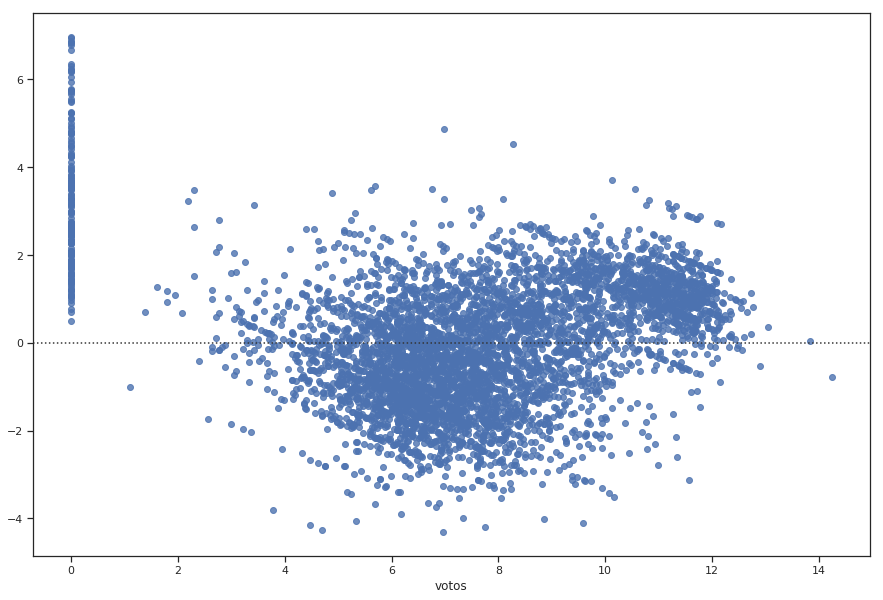

In [67]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **Decision Tree Regressor** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0). Entretanto, o modelo não consegue prever bem quando os candidatos recebem zero votos.

#### **_Epsilon-Support Vector Regressor_**

In [68]:
predictions = svr.predict(X_test)
print("RMSE SVR - Test: {:2.10}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))))

RMSE SVR - Test: 2.235375076


##### **Plot Resíduos vs Predições - SVR**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

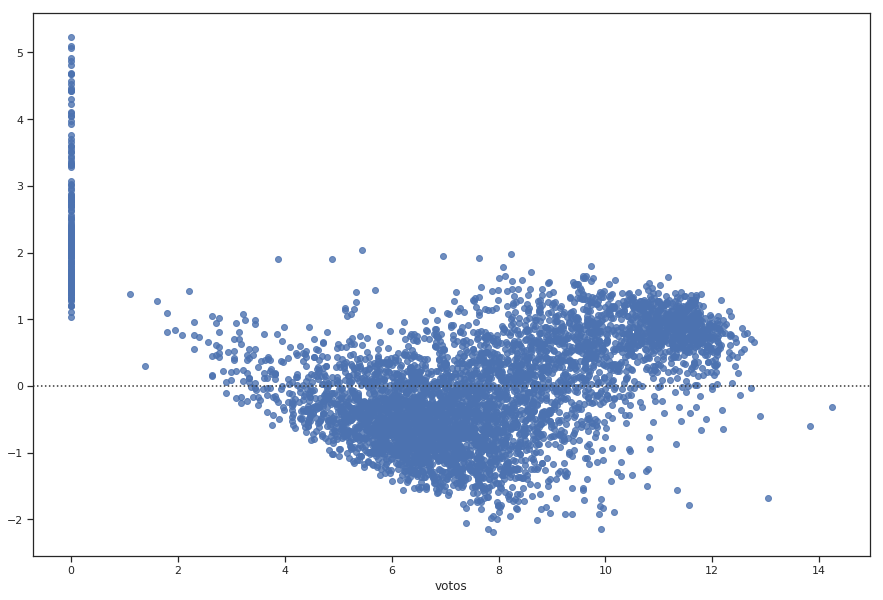

In [69]:
sns.residplot(y_test, predictions)

Como vemos, nosso modelo **SVR** é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0). Entretanto, o modelo não consegue prever bem quando os candidatos recebem zero votos.

### Conclusão

Como vemos, o melhor modelo quando utilizamos os dados de teste é o modelo **Lasso Regressor**, com o modelo **Ridge Regressor** bem próximo dele em termos de RMSE.

## EXTRA - Usando Pipelines e GridSearch do Scikit Learn

Abaixo nós fazemos alguns pipelines e grid searches com os mesmos algoritmos usados acima com o intuito de checar se os valores obtidos são correspondentes.

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def rmse_function(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

scorer = make_scorer(rmse_function, greater_is_better=False)

# Construct some pipelines
pipe_lr = Pipeline([('reg', LinearRegression())])
pipe_rf = Pipeline([('reg', RandomForestRegressor())])
pipe_lasso = Pipeline([('reg', LassoCV())])
pipe_ridge = Pipeline([('reg', RidgeCV())])
pipe_knn = Pipeline([('reg', KNeighborsRegressor())])
pipe_dt = Pipeline([('reg', DecisionTreeRegressor())])
pipe_svr = Pipeline([('reg', SVR())])


param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

grid_params_lr = [{}] 

grid_params_lasso = [{'reg__alphas' : [[5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5, 1e-6]],
                      'reg__max_iter' : [1e5],
                      'reg__random_state' : [2]}]

grid_params_ridge = [{'reg__alphas' : [[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]]}]

grid_params_rf = [{}]

grid_params_knn = [{'reg__n_neighbors' : [1, 3, 5, 7, 10, 15, 18, 21]}]

grid_params_dt = [{'reg__random_state' : [2],
                   'reg__max_depth' : [5, 10, 50]}]

grid_params_svr = [{'reg__C': [1e0, 1e1, 1e2, 1e3]}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator = pipe_lr,
                param_grid = grid_params_lr,
                scoring = scorer,
                cv = 5) 

gs_rf = GridSearchCV(estimator = pipe_rf,
                param_grid = grid_params_rf,
                scoring = scorer,
                cv = 5, 
                n_jobs = jobs)

gs_lasso = GridSearchCV(estimator = pipe_lasso,
                       param_grid = grid_params_lasso,
                       scoring = scorer,
                       cv = 5,
                       n_jobs = jobs)

gs_ridge = GridSearchCV(estimator = pipe_ridge,
                       param_grid = grid_params_ridge,
                       scoring = scorer,
                       cv = 5,
                       n_jobs = jobs)

gs_knn = GridSearchCV(estimator = pipe_knn,
                     param_grid = grid_params_knn,
                     scoring = scorer,
                     cv = 5,
                     n_jobs = jobs)

gs_dt = GridSearchCV(estimator = pipe_dt,
                    param_grid = grid_params_dt,
                    scoring = scorer,
                    cv = 5,
                    n_jobs = jobs)

gs_svr = GridSearchCV(estimator = pipe_svr,
                     param_grid = grid_params_svr,
                     scoring = scorer,
                     cv = 5,
                     n_jobs = jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_rf, gs_ridge, gs_lasso, gs_knn, gs_dt, gs_svr]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Linear Regressor', 1: 'Random Forest Regressor', 
            2: 'Ridge Regressor', 3: 'Lasso Regressor', 
            4: 'KNN Regressor', 5: 'Decision Tree Regressor',
            6: 'SVR Regressor'}


# Fit the grid search objects
print('Performing model optimizations...')
best_rmse = float("inf")
best_reg = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best RMSE for training set: %.10f' % -gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    
    # Validation data accuracy of model with best params
    print('Test set RMSE for best params: %.10f ' % rmse)
    
    # Track best (smallest rmse) model
    if best_rmse > rmse:
        best_rmse = rmse
        best_gs = gs
        best_reg = idx
        
print('\nRegressor with best test set RMSE: ** %s **' % grid_dict[best_reg])

Performing model optimizations...

Estimator: Linear Regressor
Best params: {}
Best RMSE for training set: 99407110.4764963537
Test set RMSE for best params: 1198254362.5742094517 

Estimator: Random Forest Regressor
Best params: {}
Best RMSE for training set: 0.9967692539
Test set RMSE for best params: 1.7999328975 

Estimator: Ridge Regressor
Best params: {'reg__alphas': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}
Best RMSE for training set: 0.9266521932
Test set RMSE for best params: 1.6934958764 

Estimator: Lasso Regressor
Best params: {'reg__alphas': [0.5, 0.1, 0.05, 0.001, 0.0001, 1e-05, 1e-06], 'reg__max_iter': 100000.0, 'reg__random_state': 2}
Best RMSE for training set: 0.9273295451
Test set RMSE for best params: 1.6921938052 

Estimator: KNN Regressor
Best params: {'reg__n_neighbors': 21}
Best RMSE for training set: 1.0027185226
Test set RMSE for best params: 1.8083716796 

Estimator: Decision Tree Regressor
Best params: {'reg__max_depth': 5, 'reg__random_state': 2}
Best 

### Conclusão

Como se observa acima, o melhor modelo encontrado foi o modelo **Lasso Regressor** em termos de RMSE, com o modelo **Ridge Regressor** bem próximo dele em termos de RMSE.

Entretanto os valores de RMSE são distintos dos valores encontrados acima. Isso pode se dever ao ajuste dos parâmetros dos modelos, feitos durante a própria busca, e/ou por alguma diferença na função de scoring, que talvez tenha passado despercebida pela nossa análise.